In [2]:
from pathlib import Path
from textwrap import dedent
from scipy.optimize import curve_fit
from skimage.io import imsave
from jinja2 import Template
import re
import shutil
import warnings
import numpy as np
import pandas as pd
import pyvista as pv
import cantera as ct
import matplotlib.pyplot as plt
import cfdtoolbox as cfd
import cfdtoolbox.foam as fu
import cfdtoolbox.prep as prep

A parametric mesh was conceived with `gmsh` scripting. Next we execute the system command to generate `msh2` format that can be read by `gmshToFoam` later.

**TODO:** use `gmsh` direct from Python and write mesh here without system call.

We visualize the mesh applying a 10-fold magnification over y axis to check the grading.

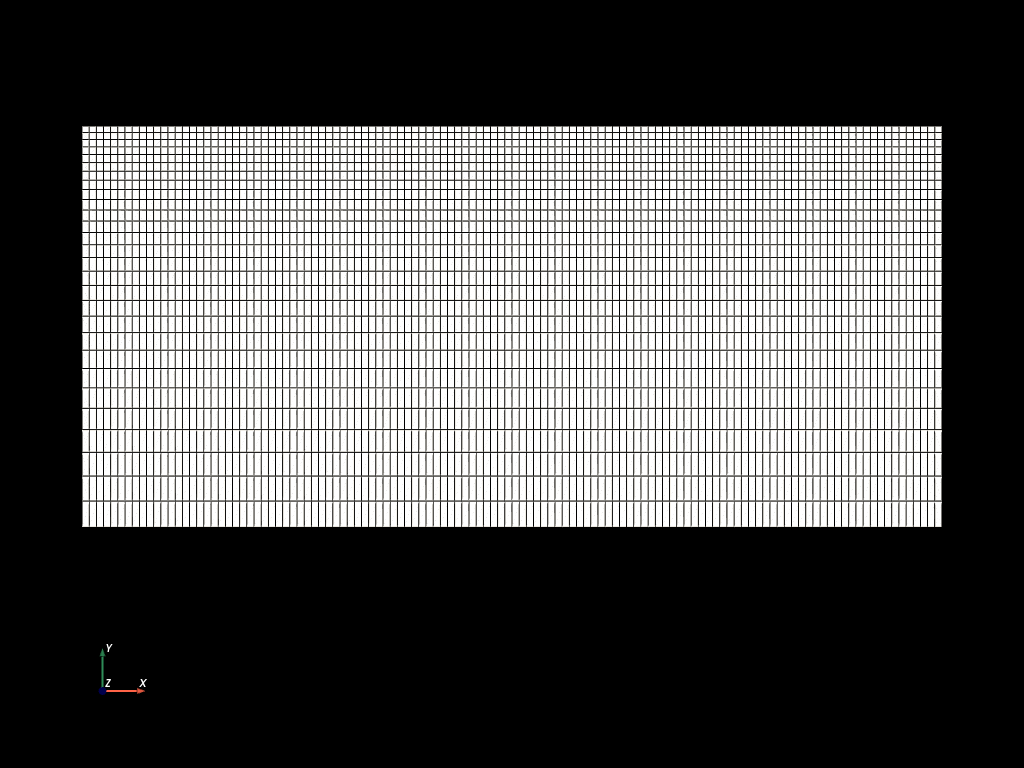

In [12]:
cpos = ((0.3, 0.005, 1.0),
        (0.3, 0.005, 0.0),
        (0.0, 0.000, 0.0))

mtm = np.diag([1, 20, 1, 1])

fu.mesh.plot_mesh(case_mesh_of, cpos=cpos, mtm=mtm)

## Case fields template

## Initial conditions

Here we will simulate case number 6 of table 5.9 of the reference thesis. 

As a first step we provide temperature and pressure.

Inlet mean gas speed is computed from flow rate and reactor cross-section.

In [15]:
T = setup["T"]
P = setup["P"]

T_room = 301.0
A = np.pi * 0.014 ** 2
U = prep.sccm_to_meter_per_second(setup["Q"], T_room, P, A)

Next we compute the reference initial conditions in required units. 

Since acetylene is stored in liquid acetone, pollution of the gas is expected are discussed by [Noringa, 2009].

Composition is converted to mass fractions as required by `reactingFoam`.

In [16]:
C = 0.36
X = {"N2":       0.64,
     "C2H2":     0.980 * C,
     "CH3COCH3": 0.018 * C,
     "CH4":      0.002 * C}

gas = ct.Solution(case_mech_ct, "gas")
gas.TPX = T, P, X

Y = gas.mass_fraction_dict()
Y["total"] = sum(Y.values())
pd.DataFrame.from_dict([Y])

,C2H2,CH3COCH3,CH4,N2,total
0,0.334007,0.013684,0.00042,0.651889,1.0


Since the wedge boundary conditions is shared by all variables we create a dictionary for storing it.

Given the low speeds and low pressure of the problem a laminar model is created.

In `combustionProperties` we set `active` to `true`, otherwise chemistry is not solved. I find this particularly intriguing because in `chemistryProperties` we have already a flag `chemistry` to turn it on/off. Need to clarify why both are required.

Finally we set gravity on vertical axis and the `thermophysicalProperties` file, which points to the mechanism and thermodynamic properties files.

Transport properties are composition dependent through a Sutherland model and thermodynamic properties are provided by JANAF polynomials.

## System

In `controlDict` we set a small time-step required for properly integrating chemistry initially.

Actually `reactingFoam` will perform a pseudo-time-stepping and while adjusting to keep Courant number below 0.25 it will eventually converge to steady state.

That is the reason why we use a high `endTime`: interpret each time step as an iteration, it is not physically right (unless you keep time-step as low as the stiffness of your case requires, here it would be about 1.0e-07 and computation would take forever).

Regarding `fvSchemes` we use an implicit time-stepping with `backward` for improved stability and limited divergent schemes in most cases.

For `fvSolution` we tighten convergence criteria for species and energy.

Configuration of PIMPLE remains mostly standard.

It is unrealistic to simulate chemical kinetics without parallelism.

Here we split the system in 4 processors along the flow direction, leading to 3 interfaces.

## Generate case

We still need to convert mesh to OpenFOAM format with `gmshToFoam`.

It is good practice to check mesh quality and keep a report of it with `checkMesh`.

File `constant/polyMesh/boundary` has to be edited to declare the wedges.

This can be done with `pyFoamChangeBoundaryType.py` from `pyfoam` package.

Decomposition of domain over multiple processors is reached with `decomposePar`.

Finally the case is ready to be launched though `mpirun` or alternatively with `foamJob`.

You can generate XY data for plotting convergence by running `foamLog log.reactingFoam`.

## Post-processing

Chemical composition units output by `reactingFoam` are not convenient for analysis.

Below we make use of Cantera to perform conversion of compositions into mole fractions.

In [35]:
def run_post_processing(latest_step):
    """ Post-process case data and return its VTK mesh. """
    mesh = pv.read(latest_step)
    
    print(f"Processing {latest_step}")
    print(f"Time = {mesh['TimeValue'][0]}")
    
    # With T straight it doesn't work (maybe transposal?)!
    mesh.point_data["Temperature [K]"] = np.array(mesh.point_data["T"])
    mesh.point_data["Velocity-X [m/s]"] = np.array(mesh.point_data["U"][:, 0])

    gas = ct.Solution(case_mech_ct)
    mass_frac_df = pd.DataFrame({species: mesh.point_data[species] 
                                 for species in gas.species_names})
    mass_frac_df["T"] = mesh.point_data["T"]
    mass_frac_df["P"] = mesh.point_data["p"]

    mole_frac_df = []
    for k, row in mass_frac_df.iterrows():
        gas.TPY = row["T"], row["P"], row[gas.species_names]
        mole_frac_df.append(gas.mole_fraction_dict())

    mole_frac_df = pd.DataFrame(mole_frac_df)

    for species in mole_frac_df.columns:
        mesh.point_data[f"X({species})"] = mole_frac_df[species].to_numpy()
        
    return mesh

These elements constitute de final result, which can now be visualized.

In [36]:
def display_results(latest_step):
    """ Generate solution plots for analysis of results. """
    cpos = ((0.3, 0.006, 1.0),
            (0.3, 0.006, 0.0),
            (0.0, 0.0, 0.0))

    opts = dict(
        cmap="jet",
        pbr=False,
        scalar_bar_args=dict(
            height=0.1,
            width=0.9, 
            vertical=False, 
            position_x=0.05,
            position_y=0.12,
            color="w",
            n_colors=12,
            n_labels=7,
            fmt="%.3f"
        )
    )

    lopts = dict(color="k", line_width=1)

    mesh = run_post_processing(latest_step)
    midplane = mesh.slice(normal=[0, 0, 1])

    p = pv.Plotter(shape="2|2", notebook=True)
    p.set_background(color="k")

    p.subplot(0)
    opts["scalar_bar_args"]["fmt"] = "%.2f"
    p.add_mesh(midplane.copy(), **opts, scalars="Velocity-X [m/s]")
    p.add_mesh(midplane.contour(10, scalars="Velocity-X [m/s]"), **lopts)

    p.subplot(1)
    opts["scalar_bar_args"]["fmt"] = "%.3f"
    p.add_mesh(midplane.copy(), **opts, scalars="X(C2H2)")
    p.add_mesh(midplane.contour(10, scalars="X(C2H2)"), **lopts)

    p.subplot(2)
    opts["scalar_bar_args"]["fmt"] = "%.4f"
    p.add_mesh(midplane.copy(), **opts, scalars="X(H2)")
    p.add_mesh(midplane.contour(10, scalars="X(H2)"), **lopts)

    p.subplot(3)
    opts["scalar_bar_args"]["fmt"] = "%.0f"
    p.add_mesh(midplane.copy(), **opts, scalars="Temperature [K]")
    p.add_mesh(midplane.contour(5, scalars="Temperature [K]"), **lopts)

    p.link_views()
    p.camera.model_transform_matrix = np.diag([1, 20, 1, 1])
    p.show(cpos=cpos)

    imsave(f"media/foam-day-16-tutorial-02-pyrolysis_{selected}.png", p.image)
    
    return mesh

In [37]:
# Keep this here to prevent automatic execution
assert False, "Manually run the next commands"

AssertionError: Manually run the next commands

To provide full system visualization we need to run `reconstructPar`.

Option `-newTimes` is provided to process only those steps not already converted.

Since post-processing is carried out with `pyvista` we convert all files to `VTK` format with `foamToVTK`.

Notice that option `-newTimes` is not available in this case and we convert only the latest.

In [ ]:
cfd.run_cmd(case, "log.reconstructPar",
            f". {source} && reconstructPar -newTimes")

cfd.run_cmd(case, "log.foamToVTK",
            f". {source} && foamToVTK -latestTime")

vtk_files = Path(case) / "VTK"
latest_step = [str(f) for f in vtk_files.iterdir() if f.is_dir()]
latest_step.sort(key=lambda f: int(re.sub('\D', '', f)))

mesh = display_results(latest_step[-1] + "/internal.vtu")

Running from cases/foam-day-16-tutorial-02-pyrolysis_12
Running from cases/foam-day-16-tutorial-02-pyrolysis_12
Processing cases/foam-day-16-tutorial-02-pyrolysis_12/VTK/foam-day-16-tutorial-02-pyrolysis_12_97681/internal.vtu
Time = 219.9995574951172
